<a href="https://colab.research.google.com/github/Adrianus-Bagas/Emotion-Detection/blob/main/Emotion_Detection_(Preprocessing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteksi Emosi Melalui Audio

## 1. Import beberapa libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Memuat data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Tess = '/content/drive/MyDrive/data audio/'
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df

,Emotions,Path
0,sad,/content/drive/MyDrive/data audio/YAF_sad/YAF_...
1,sad,/content/drive/MyDrive/data audio/YAF_sad/YAF_...
2,sad,/content/drive/MyDrive/data audio/YAF_sad/YAF_...
3,sad,/content/drive/MyDrive/data audio/YAF_sad/YAF_...
4,sad,/content/drive/MyDrive/data audio/YAF_sad/YAF_...
...,...,...
1595,happy,/content/drive/MyDrive/data audio/OAF_happy/OA...
1596,happy,/content/drive/MyDrive/data audio/OAF_happy/OA...
1597,happy,/content/drive/MyDrive/data audio/OAF_happy/OA...
1598,happy,/content/drive/MyDrive/data audio/OAF_happy/OA...


## 3. Audio Preprocessing

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
sample_rate

22050

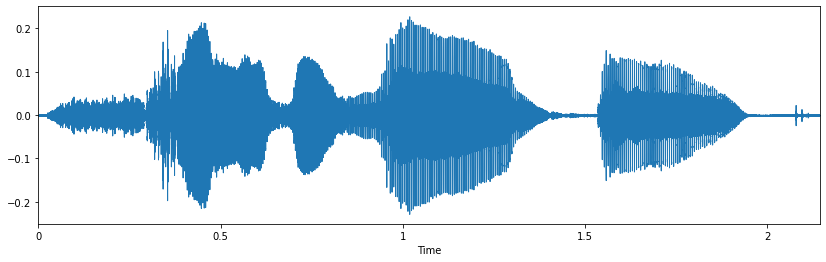

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

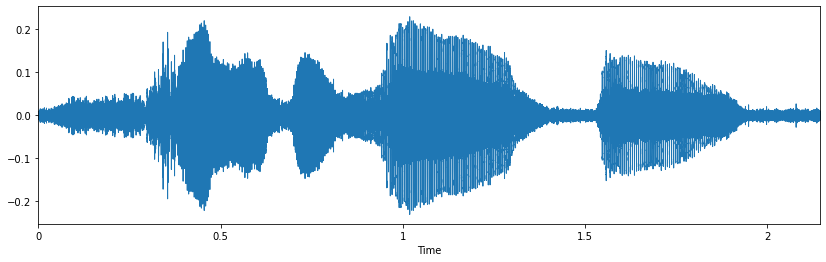

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

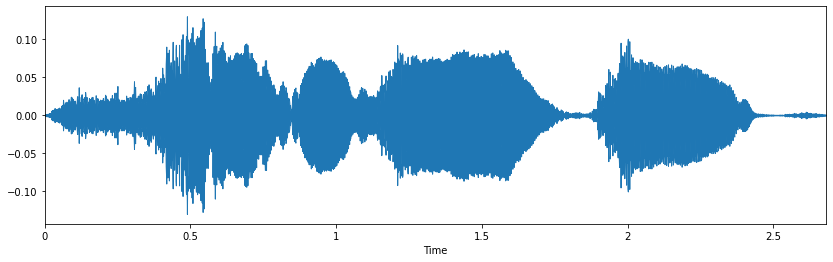

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

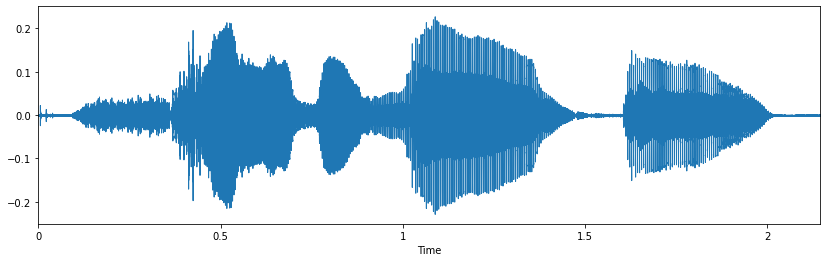

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

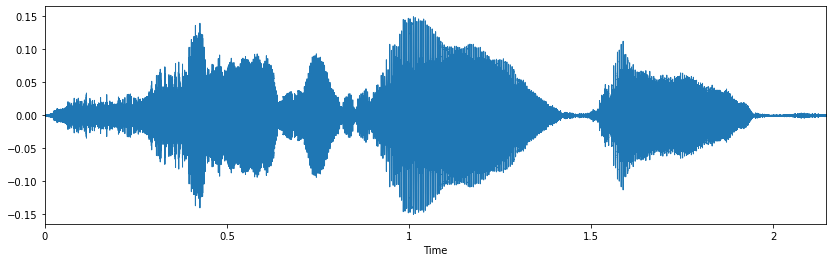

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
def extract_features(data):
    result = np.array([])
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), df.Path.shape

(4800, 4800, (1600,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/dataset/features.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-399.742432,100.436081,9.187292,28.390308,-6.561333,16.537472,-0.138621,-8.180938,1.366691,1.567494,...,-1.330374,-11.792912,14.240981,-11.331120,-1.957271,-1.172745,-0.676887,-5.290711,-3.465883,sad
1,-359.149395,71.894877,17.545031,18.976195,-0.390334,9.577103,1.568283,-6.067213,1.954241,-2.368474,...,-5.174180,-5.000865,7.009338,-6.859118,-5.140312,0.024275,-3.061469,-2.985632,-4.941814,sad
2,-461.433105,93.952171,9.721594,25.440495,-5.660292,16.642614,-3.905573,-8.742842,3.246967,-2.633952,...,-4.004335,-4.990000,13.022542,-15.329729,1.545783,-1.163409,-1.142039,-3.984202,-3.492022,sad
3,-407.631195,99.247940,10.754412,27.849697,2.521706,14.629902,-2.598167,-11.795385,5.944390,-3.853054,...,2.614057,-12.985439,10.140218,-12.777110,-2.410043,-1.422408,-1.650963,-6.968535,-6.341195,sad
4,-307.760183,48.053203,18.740791,11.992347,4.532837,5.695790,-1.903840,-5.020708,1.605943,-2.924321,...,-5.029605,-3.504687,0.704473,-6.390824,-5.708613,-2.521811,-3.925443,-3.800466,-4.812770,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,-404.828807,74.550954,16.057916,-4.880032,0.563853,1.578211,-9.109502,-10.532808,-9.339563,-4.653175,...,-8.197384,-5.186045,-1.926364,-2.145762,-1.012196,1.395253,4.627178,1.291640,-5.290825,happy
4796,-544.494141,137.743301,8.655626,-17.808264,-1.746074,2.450433,-18.456900,-14.074989,-13.861665,-3.334609,...,-5.868994,-7.610136,-0.868871,-2.432390,3.335274,-0.408585,4.448386,-5.163003,-9.341989,happy
4797,-471.726929,116.254143,24.741329,-13.907975,-10.322044,3.570961,-6.128961,-3.667096,-17.369890,-3.986244,...,-6.656944,-6.157938,-2.079576,-3.540452,6.148648,-3.185794,9.152263,1.120421,-3.447200,happy
4798,-327.124668,48.649999,15.751025,-5.820897,-7.573235,-1.919178,-1.067227,-5.348863,-8.856018,-8.608043,...,-6.620527,-5.143201,-3.540646,-1.242687,1.519939,2.108145,2.918989,0.778003,-3.033096,happy
